In [11]:
import tensorflow as tf
import tensorflow_datasets as tfds

2024-09-17 22:01:20.851805: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-17 22:01:20.854121: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-17 22:01:20.862681: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-17 22:01:20.877772: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-17 22:01:20.882130: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-17 22:01:20.892308: I tensorflow/core/platform/cpu_feature_gu

In [12]:
BUFFER_SIZE=10000
BATCH_SIZE=128
NUM_EPOCHS=20

In [15]:
mnist_dataset,mnist_info=tfds.load(name='mnist',with_info=True,as_supervised=True)

In [17]:
mnist_train, mnist_test = mnist_dataset['train'], mnist_dataset['test']
mnist_train

<_PrefetchDataset element_spec=(TensorSpec(shape=(28, 28, 1), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [22]:
def scale(image, label):
    image = tf.cast(image, tf.float32)
    image /= 255.0
    image = tf.expand_dims(image, axis=-1)  # Add channel dimension (28, 28, 1)
    return image, label

In [24]:
train_and_validation_data = mnist_train.map(scale).shuffle(BUFFER_SIZE)
test_data = mnist_test.map(scale)

In [26]:
num_validation_samples = int(0.1 * mnist_info.splits['train'].num_examples)
num_test_samples = mnist_info.splits['test'].num_examples

In [28]:
num_test_samples=mnist_info.splits['test'].num_examples
num_test_samples=tf.cast(num_test_samples,tf.int64)

In [30]:
train_and_validation_data=train_and_validation_data.shuffle(BUFFER_SIZE)

In [32]:
train_data=train_and_validation_data.skip(num_validation_samples)
validation_data=train_and_validation_data.take(num_validation_samples)

In [34]:
train_data=train_data.batch(BATCH_SIZE)
validation_data=validation_data.batch(num_validation_samples)
test_data=test_data.batch(num_test_samples)

In [36]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(50, 5, activation='relu', input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(50, 3, activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(10)
])

/home/bizmotion/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [39]:
model.summary(line_length=75)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃ Layer (type)                   ┃ Output Shape            ┃      Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                │ (None, 24, 24, 50)      │        1,300 │
├────────────────────────────────┼─────────────────────────┼──────────────┤
│ max_pooling2d (MaxPooling2D)   │ (None, 12, 12, 50)      │            0 │
├────────────────────────────────┼─────────────────────────┼──────────────┤
│ conv2d_1 (Conv2D)              │ (None, 10, 10, 50)      │       22,550 │
├────────────────────────────────┼─────────────────────────┼──────────────┤
│ max_pooling2d_1 (MaxPooling2D) │ (None, 5, 5, 50)        │            0 │
├────────────────────────────────┼─────────────────────────┼──────────────┤
│ flatten (Flatten)              │ (None, 1250)            │            0 │
├────────────────────────────────┼─────────────────────────┼──────────────┤
│ dense (Dense)                  │ (None, 10)              │       12,510 │
└────────────────────────────────┴─────────────────────────┴──────────────┘

 Total params: 36,360 (142.03 KB)

 Trainable params: 36,360 (142.03 KB)

 Non-trainable params: 0 (0.00 B)

In [41]:
loss_fn=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

In [43]:
model.compile(optimizer='adam',loss=loss_fn,metrics=['accuracy'])

In [45]:
early_stopping=tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    mode='auto',
    min_delta=0,
    patience=2,
    verbose=0,
    restore_best_weights=True
)

In [47]:
model.fit(
    train_data,
    epochs=NUM_EPOCHS,
    callbacks=[early_stopping],
    validation_data=validation_data,
    verbose=2
)

Epoch 1/20


2024-09-17 22:02:05.758437: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 691200000 exceeds 10% of free system memory.


422/422 - 19s - 45ms/step - accuracy: 0.9204 - loss: 0.2719 - val_accuracy: 0.9738 - val_loss: 0.0867
Epoch 2/20


2024-09-17 22:02:26.326354: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 691200000 exceeds 10% of free system memory.


422/422 - 21s - 49ms/step - accuracy: 0.9781 - loss: 0.0713 - val_accuracy: 0.9837 - val_loss: 0.0565
Epoch 3/20


2024-09-17 22:02:43.137158: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 691200000 exceeds 10% of free system memory.


422/422 - 17s - 40ms/step - accuracy: 0.9841 - loss: 0.0518 - val_accuracy: 0.9862 - val_loss: 0.0477
Epoch 4/20


2024-09-17 22:03:00.792231: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 691200000 exceeds 10% of free system memory.


422/422 - 18s - 42ms/step - accuracy: 0.9874 - loss: 0.0419 - val_accuracy: 0.9887 - val_loss: 0.0424
Epoch 5/20


2024-09-17 22:03:20.070294: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 691200000 exceeds 10% of free system memory.


422/422 - 19s - 46ms/step - accuracy: 0.9891 - loss: 0.0361 - val_accuracy: 0.9907 - val_loss: 0.0294
Epoch 6/20
422/422 - 21s - 51ms/step - accuracy: 0.9902 - loss: 0.0315 - val_accuracy: 0.9895 - val_loss: 0.0344
Epoch 7/20
422/422 - 21s - 49ms/step - accuracy: 0.9916 - loss: 0.0270 - val_accuracy: 0.9918 - val_loss: 0.0312


In [49]:
test_loss,test_accuracy = model.evaluate(test_data)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9890 - loss: 0.0325


In [51]:
print('Test loss: {0: .4f}. Test accuracy: {1: .2f}%'.format(test_loss,test_accuracy*100.))

Test loss:  0.0325. Test accuracy:  98.90%


In [53]:
import matplotlib.pyplot as plt
import numpy as np

In [55]:
for images, labels in test_data.take(1):
    images_test = images.numpy()
    labels_test = labels.numpy()

# Reshape the images into 28x28 form, suitable for matplotlib (original dimensions: 28x28x1)
images_plot = np.reshape(images_test, (10000,28,28))

2024-09-17 22:13:50.434131: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


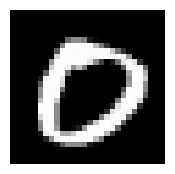

Label: 0


In [69]:
i = 7


# Plot the image
plt.figure(figsize=(2, 2))
plt.axis('off')
plt.imshow(images_plot[i-1], cmap="gray", aspect='auto')
plt.show()

# Print the correct label for the image
print("Label: {}".format(labels_test[i-1]))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


<BarContainer object of 10 artists>

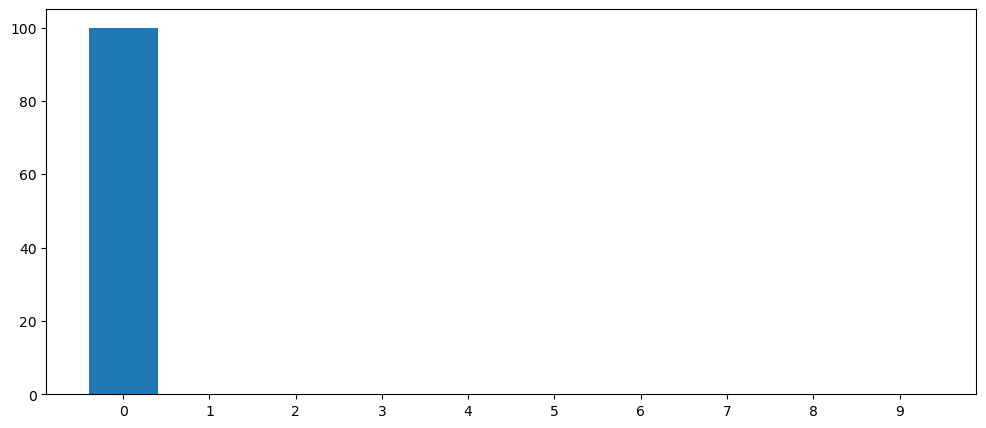

In [71]:
# Obtain the model's predictions (logits)
predictions = model.predict(images_test[i-1:i])

# Convert those predictions into probabilities (recall that we incorporated the softmaxt activation into the loss function)
probabilities = tf.nn.softmax(predictions).numpy()
# Convert the probabilities into percentages
probabilities = probabilities*100


# Create a bar chart to plot the probabilities for each class
plt.figure(figsize=(12,5))
plt.bar(x=[1,2,3,4,5,6,7,8,9,10], height=probabilities[0], tick_label=["0","1","2","3","4","5","6","7","8","9"])